In [21]:
# Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import stumpy
from matplotlib.patches import Rectangle
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import Image
from scipy.stats import boxcox
from pmdarima import auto_arima 

# For clustering that did not work
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance,TimeSeriesResampler



## Task 5A + B

,close
count,25.000000
mean,0.269957
std,0.008181
min,0.255529
25%,0.263168
50%,0.269128
75%,0.275230
max,0.286742


C:\Users\victo\AppData\Local\Temp\ipykernel_29272\473007640.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax, label='Normalized market average closing price').set_xticklabels(dates_to_plot)


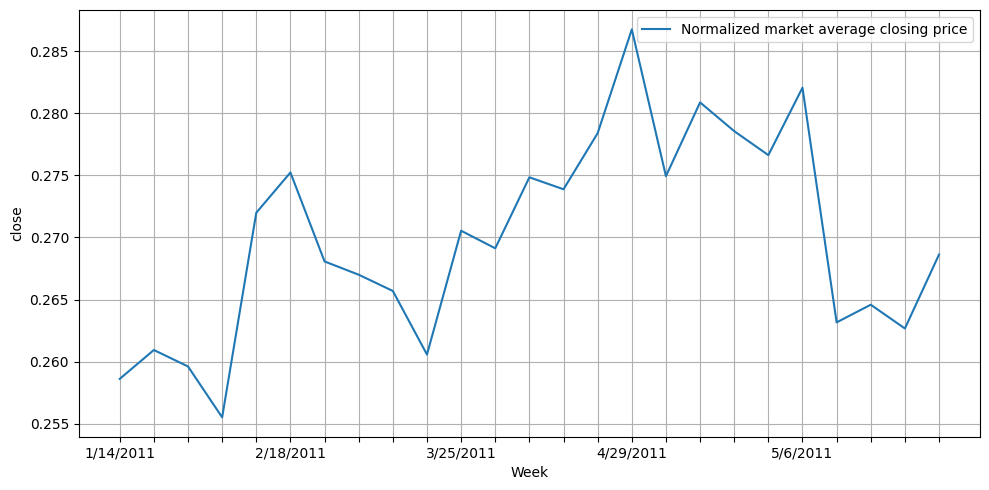

In [22]:
# Dataset has no missing values, the data can not contain missing values since the domain does not allow this. 

# Loading the data, changing the format and datatype of the 'close' column
dow_jones = pd.read_csv('dow_jones_index.data')
dow_jones['close'] = dow_jones['close'].replace({'\\$': ''}, regex=True).astype(float)

# Scaling the data in the 'close' column
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(np.array(dow_jones['close']).reshape(-1, 1))
dow_jones = dow_jones.assign(close=scaled_data)

# Creting a new dataframe and aggregating the values as to get the scaled average market value per week
close_df = dow_jones[['date', 'close']]
close_df = close_df.groupby(by=['date']).mean()

# Summarizing the data
display(close_df.describe())

# Plotting the timeseries
i = 0
dates_to_plot = []
for date in close_df.index:
    if i % 5 == 0 or i == len(close_df.index):
        dates_to_plot.append(date)
    else:
        dates_to_plot.append('')
    i+=1


fig, ax = plt.subplots(1,1, figsize = (10, 5))
sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax, label='Normalized market average closing price').set_xticklabels(dates_to_plot)
ax.legend()
ax.set_xlabel('Week')
ax.grid()
plt.tight_layout()
plt.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_29272\818249576.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1, label='Normalized market average').set_xticklabels(dates_to_plot)


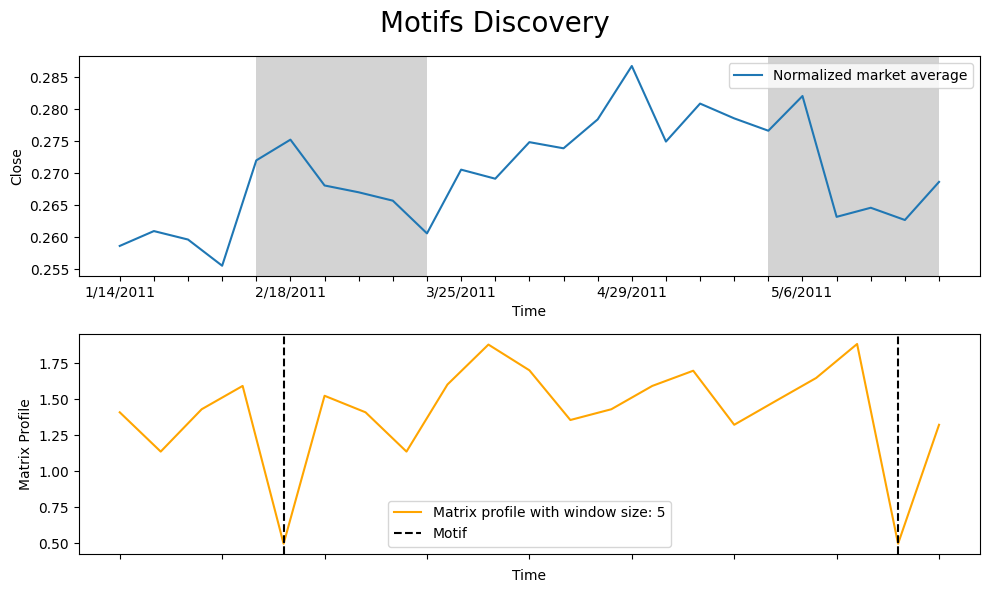

In [23]:
# Creating the matrix profile
m=5
matrix_profile = stumpy.stump(close_df['close'], m=m)
profile = np.array(matrix_profile)[:, 0]

#Finding motifs by getting the index of the smallest values in the matrix profile
motif_idx = np.argsort(profile)[0]
nearest_neighbor_idx = matrix_profile[motif_idx, 1]

# Plotting, inspiration taken from the stumpylibrary
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.suptitle('Motifs Discovery', fontsize=20)

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1, label='Normalized market average').set_xticklabels(dates_to_plot)
ax1.set_ylabel('Close')
ax1.set_xlabel('Time')
rect = Rectangle((motif_idx, 0), m, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((nearest_neighbor_idx, 0), m, 40, facecolor='lightgrey')
ax1.add_patch(rect)

sns.lineplot(y=profile, x=range(len(profile)), label=f'Matrix profile with window size: {m}', ax=ax2, color='orange').set_xticklabels([])
ax2.set_xlabel('Time')
ax2.set_ylabel('Matrix Profile')
ax2.axvline(x=motif_idx, linestyle="dashed", color='black', label='Motif')
ax2.axvline(x=nearest_neighbor_idx, linestyle="dashed", color='black')

plt.legend()
plt.tight_layout()
plt.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_29272\3893330398.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1, label='Normalized market average').set_xticklabels(dates_to_plot)


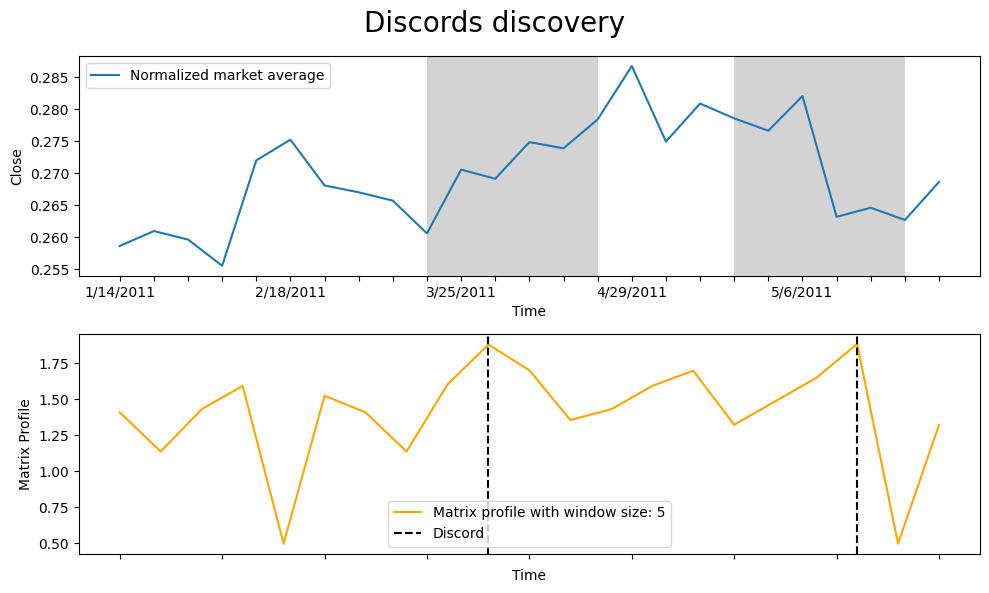

In [24]:
# Finding discords by getting the largest values
discord_idx1 = np.argsort(profile)[-1]
discord_idx2 = np.argsort(profile)[-2]

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
plt.suptitle('Discords discovery', fontsize=20)

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1, label='Normalized market average').set_xticklabels(dates_to_plot)
ax1.set_ylabel('Close')
ax1.set_xlabel('Time')
rect = Rectangle((discord_idx1, 0), m, 40, facecolor='lightgrey')
ax1.add_patch(rect)
rect = Rectangle((discord_idx2, 0), m, 40, facecolor='lightgrey')
ax1.add_patch(rect)

sns.lineplot(y=profile, x=range(len(profile)), label=f'Matrix profile with window size: {m}', ax=ax2, color='orange').set_xticklabels([])
ax2.set_xlabel('Time')
ax2.set_ylabel('Matrix Profile')
ax2.axvline(x=discord_idx1, linestyle="dashed", color='black', label='Discord')
ax2.axvline(x=discord_idx2, linestyle="dashed", color='black')

plt.legend()
plt.tight_layout()
plt.show()

5/20/2011
6/24/2011


<>:8: SyntaxWarning: invalid escape sequence '\c'
<>:8: SyntaxWarning: invalid escape sequence '\c'
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\2552846589.py:8: SyntaxWarning: invalid escape sequence '\c'
  Image(filename='Images\chatgpt_prompt1.png')


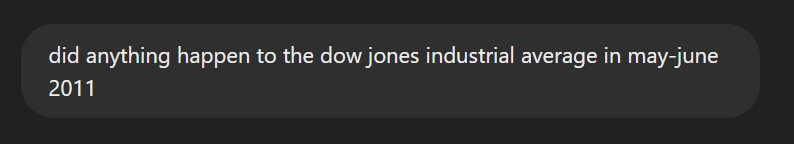

In [25]:
# Anomaly period 1 explanation
anomaly_period1_start = close_df.index[discord_idx1]
anomaly_period1_end = close_df.index[discord_idx1 + m]
print(anomaly_period1_start)
print(anomaly_period1_end)

# ChatGPT prompt to find soucres:
Image(filename='Images\chatgpt_prompt1.png')

# Found these market reports to explain the market:

# https://www.arkansasonline.com/news/2011/jun/10/stocks-rise-1st-time-june-20110610/?utm_source=chatgpt.com


# The stock market broke a six-day losing streak on Thursday, June 9, 2011, with the Dow Jones Industrial Average rising 75.42 points (0.6%) 
# to close at 12,124.36. The rally was driven by a report showing U.S. exports hit a record high in April, which improved economic growth 
# projections. The S&P 500 and Nasdaq also gained 0.7% and 0.4%, respectively.

# The previous slump, caused by poor economic reports on manufacturing, housing, hiring, and consumer confidence, had made stocks appear 
# undervalued. U.S. manufacturers benefitted from a narrower trade deficit, while higher corn prices boosted agricultural equipment stocks 
# like Deere & Co. Energy stocks rose due to a $1.19 increase in oil prices, closing at $101.93 per barrel.

# Despite the rebound, concerns lingered over high unemployment claims, Japan's earthquake impact, and Greece's debt crisis, which had been 
# weighing on markets since mid-April. Consolidated trading volume was 3.5 billion shares, with nearly twice as many stocks rising as falling.

3/18/2011
4/21/2011


<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\1992733826.py:7: SyntaxWarning: invalid escape sequence '\c'
  Image(filename='Images\chapgpt_prompt2.png')


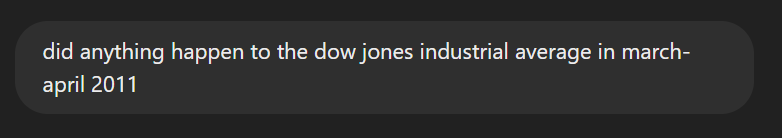

In [26]:
# Anomaly period 2 explanation
anomaly_period2_start = close_df.index[discord_idx2]
anomaly_period2_end = close_df.index[discord_idx2 + m]
print(anomaly_period2_start)
print(anomaly_period2_end)

Image(filename='Images\chapgpt_prompt2.png')

# Found these market reports to explain the market:

# https://www.publishersweekly.com/pw/by-topic/industry-news/financial-reporting/article/47142-industry-stocks-april-2011-performances.html?utm_source=chatgpt.com

# The Dow Jones Industrial Average and the Publishers Weekly Stock Index rose by similar amounts in April, with the Dow ahead 4.8% and t
# he PWSI up 4.3%. The stock prices of nine companies on the PWSI rose in the month while prices declined at four. Barnes & Noble’s stock 
# price continued to be the most volatile in the publishing and bookselling industries. 

# After falling 31% in February, the price rose 19.6% in April as investors try to figure out if B&N is a dying bricks-and-mortar bookstore 
# chain or a print/digital bookstore poised for big growth. Investors have no doubts about Amazon, as the stock price of the e-tailer ran 
# up over $15 in the month. While Wall Street tends to frown on companies that make large investments in their operations, investors seemed 
# to accept Amazon’s argument made in discussing first-quarter results that investments now will pay off in a big way in the future.

C:\Users\victo\AppData\Local\Temp\ipykernel_29272\4035053325.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax[0, 0], label='normalized market average').set_xticklabels(dates_to_plot)


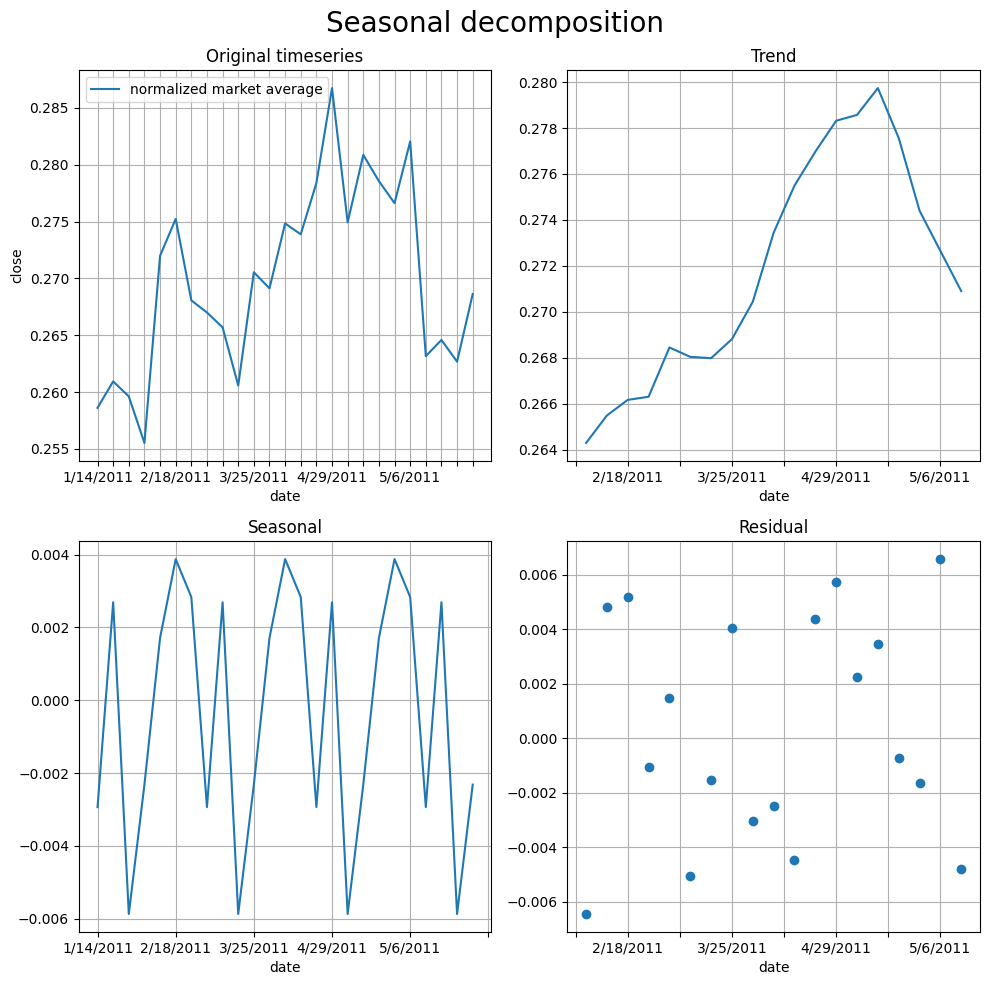

In [27]:
# Seasonal decomposition

# Applying seasonal decompotition with statsmodels.tsa
nox_decomp = seasonal_decompose(close_df['close'], model='additive', period=7)     # I choose additive model here since the variance looks to be constant for this variable

# Plotting'
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Seasonal decomposition', fontsize=20)

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax[0, 0], label='normalized market average').set_xticklabels(dates_to_plot)
ax[0, 0].set_title('Original timeseries') 
ax[0, 0].grid()

nox_decomp.trend.plot(ax=ax[0, 1])
ax[0, 1].set_title('Trend')
ax[0, 1].grid()

nox_decomp.seasonal.plot(ax=ax[1, 0])
ax[1, 0].set_title('Seasonal')
ax[1, 0].grid()

nox_decomp.resid.plot(marker='o', ax=ax[1, 1], linewidth=0)
ax[1, 1].set_title('Residual')
ax[1, 1].grid()


plt.tight_layout()
plt.show()

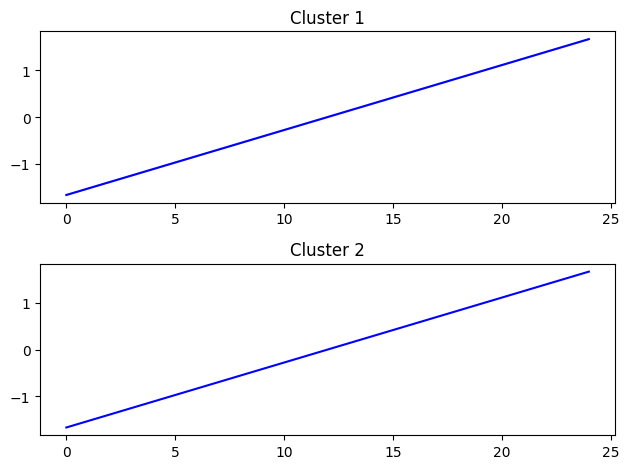

In [28]:
# Timeseries clustering with Dynamic timewarping

# Formating the data to make it suitable for clustering
X_train_clsuter = TimeSeriesResampler(sz=25).fit_transform(range(len(close_df.index)), close_df.values)
X_train_cluster= TimeSeriesScalerMeanVariance().fit_transform(X_train_clsuter)

# Creating the model and making a preduction
n_clusters = 2
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
y_pred = model.fit_predict(X_train_cluster)

# Plotting

for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X_train_cluster[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), color="blue")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

# We have tried to perform timeseries clustering with Dynamic Time Warping, but we are likely not getting any results due to the low
# amounts of datapoints in the aggregated timeseries dataframe, making it impossible for the model to find repeating paterns since
# they do not exist. We can find similar and repeating paterns in the timeseries by visually inspecing the graph. 

## Task 5C

C:\Users\victo\AppData\Local\Temp\ipykernel_29272\1797819867.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1).set_xticklabels(dates_to_plot)
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\1797819867.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', ax=ax2).set_xticklabels(dates_to_plot)


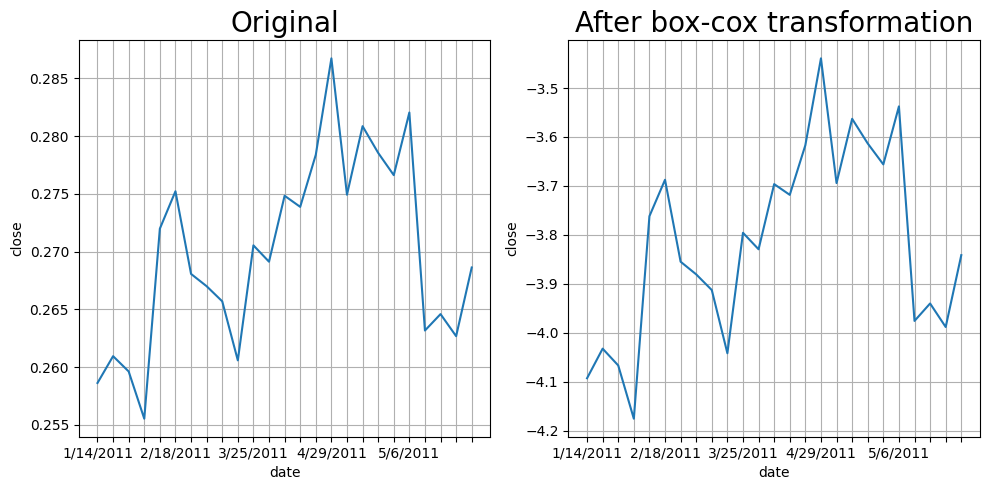

In [29]:
# Since stock markets are typically not stationary and contains trend ans seasonality components as seen in the decomposition, 
# we will use a SARIMA model to predict future values. We do however need to fix the non-constant vairance with a box-cox transformation.

# Box cox transformation 
close_df_boxcox = close_df.assign(close=boxcox(close_df['close'])[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(data=close_df, x=close_df.index, y='close', ax=ax1).set_xticklabels(dates_to_plot)
sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', ax=ax2).set_xticklabels(dates_to_plot)
ax1.grid()
ax2.grid()
ax1.set_title('Original', fontsize=20)
ax2.set_title('After box-cox transformation', fontsize=20)
plt.tight_layout()
plt.show()

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\3430399915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xtickla

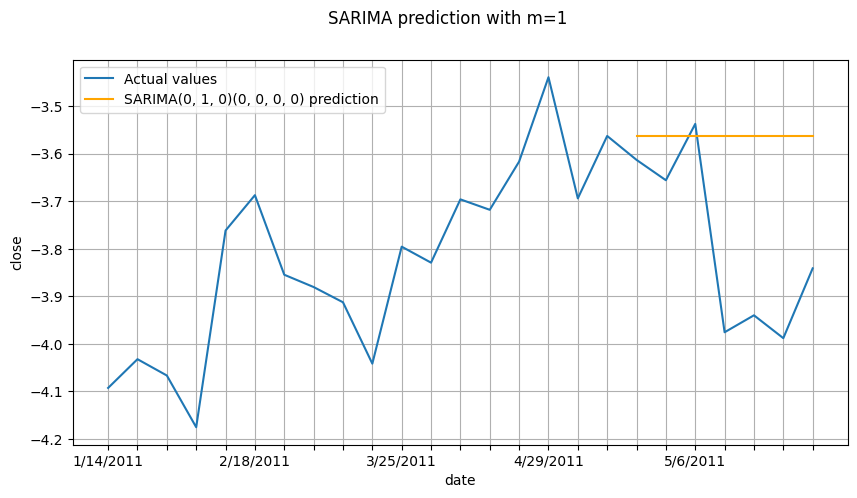

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\3430399915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xtickla

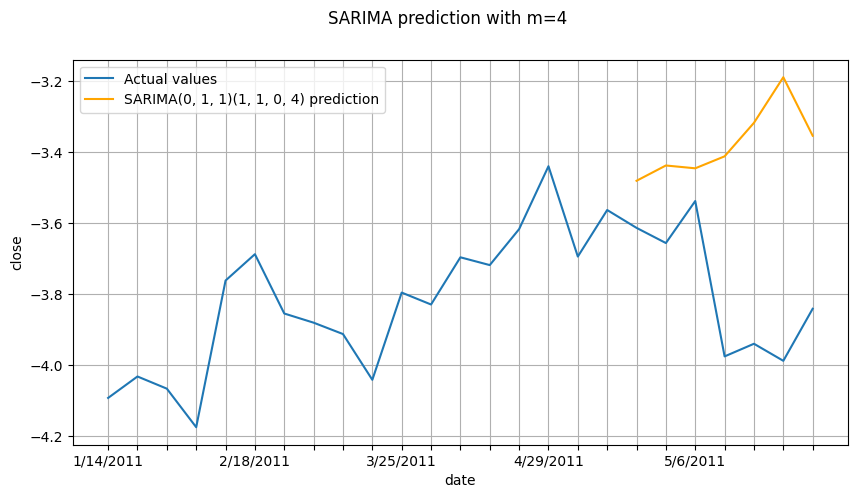

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\3430399915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xtickla

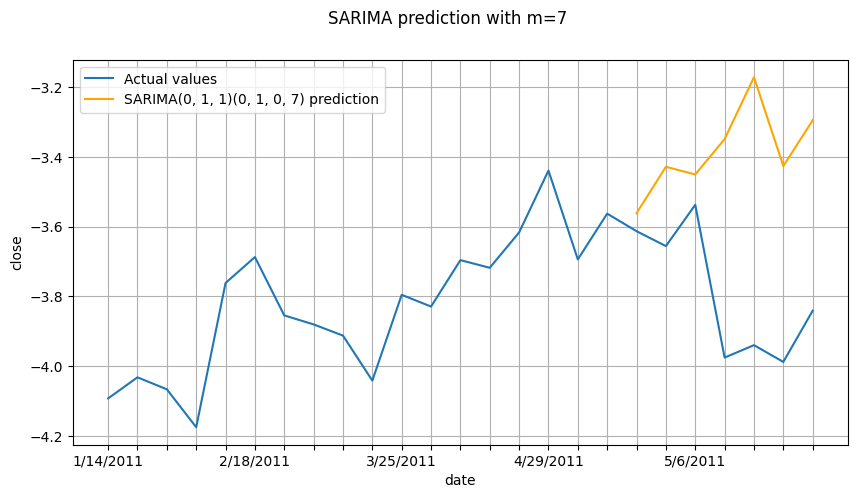

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\3430399915.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xtickla

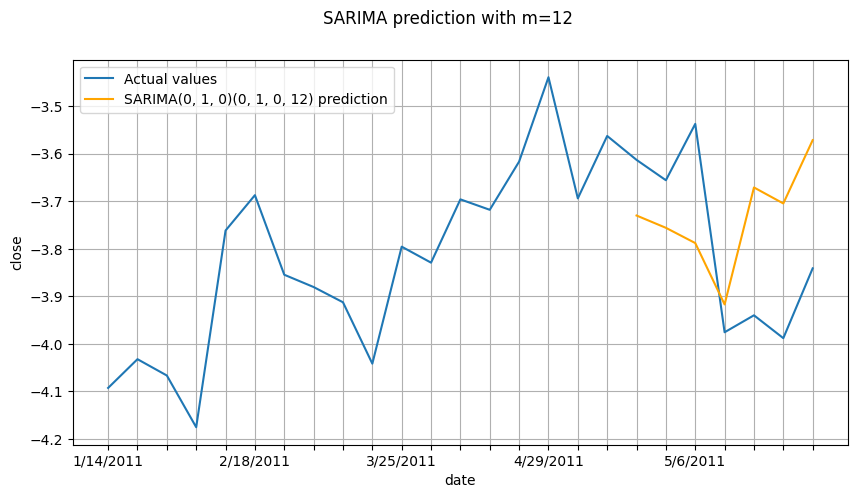

In [30]:
# 80/20 split, no validation since this is not required when working with timeseries data. 
X_train = close_df_boxcox.iloc[:18]
X_test = close_df_boxcox.iloc[18:]

# Creating a SARIMA model that automatically finds the model with the lowest AIC score though iterating over different 
# combinations of p,d,q,P,D,Q paramters. Since the m parameter of the seasonal component does not affect the AIC score
m_vals_to_try =[1, 4, 7, 12]

for m in m_vals_to_try:
    model = auto_arima(X_train, 
                       
                       start_p=1,
                       start_q=1, 
                       d=1, 
                       max_p=10, 
                       max_q=10, 
                       
                       start_P=0,
                       start_Q=0,
                       D=1,
                       max_P=10,
                       max_Q=10,

                       m=m,
                       
                       information_criterion='aic',
                       trace=False, 
                       error_action='ignore',
                       suppress_warnings=True, 
                       stepwise=True)

    model.fit(X_train)
    forecast = model.predict(n_periods=len(X_test))

    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    plt.suptitle(f'SARIMA prediction with m={m}')

    sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xticklabels(dates_to_plot)
    sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMA'+str(model.order)+str(model.seasonal_order)+' prediction')
    ax.grid()

    plt.tight_layout
    plt.legend()
    plt.show()

C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\victo\AppData\Local\Temp\ipykernel_29272\1238121576.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xtickla

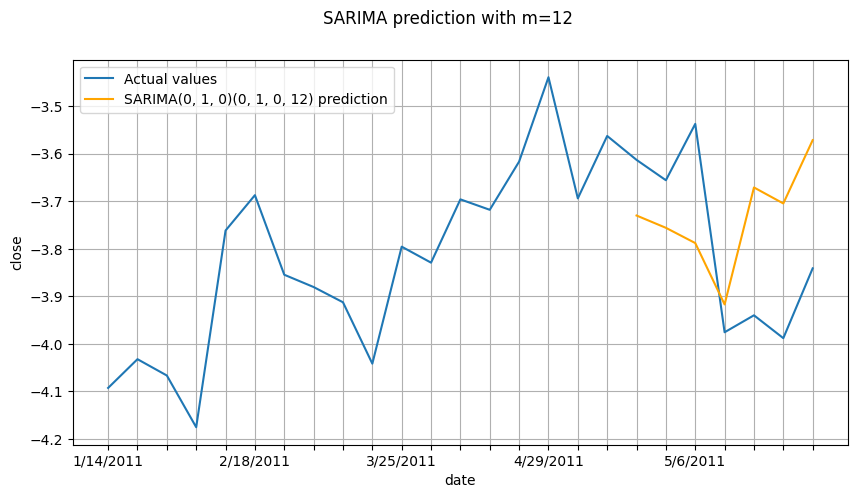

[1000, 1000, 1000, 1000, 1005.4, 1005.4, 1028.18]


C:\Users\victo\AppData\Local\Temp\ipykernel_29272\1238121576.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return np.round(float(capital * percentage), 2)


In [31]:
# The values for the predictions are not so good, but this does not matter since we only want to determine if we want to buy or sell
# from an index fund at a given day of the week, since we can not control the stock market anyway. In its most simple terms, 
# we only want to predict if the closing value will be higher or lower than it is currently. 

# Recreating the best model from above and making a prediction
model = auto_arima(X_train, 
                    
                    start_p=1,
                    start_q=1, 
                    d=1, 
                    max_p=10, 
                    max_q=10, 
                    
                    start_P=0,
                    start_Q=0,
                    D=1,
                    max_P=10,
                    max_Q=10,

                    m=12,
                    
                    information_criterion='aic',
                    trace=False, 
                    error_action='ignore',
                    suppress_warnings=True, 
                    stepwise=True)

model.fit(X_train)
forecast = model.predict(n_periods=len(X_test))

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle(f'SARIMA prediction with m={m}')

sns.lineplot(data=close_df_boxcox, x=close_df_boxcox.index, y='close', label='Actual values').set_xticklabels(dates_to_plot)
sns.lineplot(y=forecast, x=X_test.index, color='orange', label='SARIMA'+str(model.order)+str(model.seasonal_order)+' prediction')
ax.grid()

plt.tight_layout
plt.legend()
plt.show()

# Function to make trades
def make_trade(i, capital, current_actual, current_prediction, next_actual, next_prediction):
    if np.abs(next_prediction) < np.abs(current_prediction):
        percentage = np.abs(next_actual) / np.abs(current_actual)
        return np.round(float(capital * percentage), 2)
    else:
        return capital

# Function to evaluate trading strategy
def evaluate_trading_strategy(capital, X_test, forecast):
    trade_history = [capital]
    for i in range(len(forecast) - 1):
        capital = make_trade(i, capital, 
                             current_actual=X_test.values[i], 
                             current_prediction=forecast.values[i], 
                             next_actual=X_test.values[i + 1], 
                             next_prediction=forecast.values[i + 1])
        trade_history.append(capital)
    return capital, trade_history

# Example usage
real_X_test = close_df.iloc[18:]
capital = 1000
capital, trade_history = evaluate_trading_strategy(capital, real_X_test, forecast)
print(trade_history)
